# A Beginner’s Guide to Carry out Extreme Value Analysis (3)

This is the third part of "A Beginner’s Guide to Carry out Extreme Value Analysis". Upon the part 2 of this guide, we know  the GEV is the best one.

In this part, a bootstrapping procedure is introduced to drive the confidence intervals of the selected best extreme distribution.

## 1. Lets start by firing up the required libraries

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

import seaborn as sns
sns.set(style="whitegrid")
sns.set_context('notebook', font_scale=1.1)

## 2. Load data

In [54]:
data = pd.read_csv('data/fortprec.txt', sep ='\t')
df = data.groupby("year").Prec.max()
df.head()

year
1900    2.39
1901    2.32
1902    4.34
1903    0.85
1904    3.02
Name: Prec, dtype: float64

## 3. Fit GEV distribution (the best one)

In [55]:
import lmoments3 as lm
from lmoments3 import distr

gevfit = distr.gev.lmom_fit(df)
gevfit

OrderedDict([('c', -0.13012477387318533),
             ('loc', 1.3536800222811283),
             ('scale', 0.5568347579344847)])

## 4. Bootstrap confidence intervals

The calculations used a percentile interval method. The underlying idea is to 
* sample the orignal data as many as possible;
* carry out extreme value analysis on these sampled samples;
* do statistics such as means and percentiles.

All the code in this section has been adapted and simplified from that on 
* https://github.com/cgevans/scikits-bootstrap.
* https://github.com/kikocorreoso/scikit-extremes/blob/master/skextremes

All the credits shall go to them and you can find more information within each function.

In [56]:
import warnings as _warnings
from collections import OrderedDict
from numpy.random import randint as _randint

class InstabilityWarning(UserWarning):
    """Issued when results may be unstable."""
    pass

On import, make sure that InstabilityWarnings are not filtered out.

In [57]:
_warnings.simplefilter('always', InstabilityWarning)
_warnings.simplefilter('always', UserWarning)

The bootstrap_ci is the worker to carry out a series of tasks:
* sampling
* fitting gev distribution agaist samples
* do statistics

In [58]:
def bootstrap_ci(data, statfunction=np.average, alpha=0.05, n_samples=100):
    """
    Calculate the bootstrap confidence interval for a given dataset using
    the percentile interval method.

    Parameters:
    - data (array_like or tuple of array_like): Input data. If multiple
            datasets are passed as a tuple, they are processed separately.
    - statfunction (function): Function to apply to the data. The function
            should accept samples of data from the input.
    - alpha (float, optional): The percentiles to use for the confidence
            interval. Default is 0.05.
    - n_samples (int, optional): The number of bootstrap samples to use.
            Default is 100.

    Returns:
    - confidences (tuple of floats): The confidence percentiles
            specified by alpha.

    Calculation Methods:
    'pi' (Percentile Interval, Efron 13.3):
        The percentile interval method returns the specified
            confidence percentiles.

    Calculation References:
    - Efron (1993): 'An Introduction to the Bootstrap', Chapman & Hall.

    This function has been derived and simplified from the
        scikits-bootstrap package created by cgevans
        (https://github.com/cgevans/scikits-bootstrap).

    """
    def bootstrap_indexes(data, n_samples=10000):
        """
        Generate sets of bootstrap indexes given data points.

        Parameters:
        - data: Data points where axis 0 delineates points.
        - n_samples: The number of bootstrap samples to generate.

        Returns:
        - Generator for sets of bootstrap indexes.

        """
        for _ in range(n_samples):
            yield _randint(data.shape[0], size=(data.shape[0],))

    alphas = np.array([alpha / 2, 1 - alpha / 2])

    data = np.array(data)
    tdata = (data,)

    # Generate the bootstrap indexes
    bootindexes = bootstrap_indexes(tdata[0], n_samples)

    # Apply the statfunction to the generated indexes
    stat = np.array([statfunction(*(x[indexes] for x in tdata))
                    for indexes in bootindexes])
    stat.sort(axis=0)

    # Calculate confidence intervals using the Percentile Interval Method
    avals = alphas

    nvals = np.round((n_samples - 1) * avals).astype('int')

    if np.any(nvals == 0) or np.any(nvals == n_samples - 1):
        _warnings.warn(
            "Some values used extremal samples; results are probably unstable.",
            InstabilityWarning)
    elif np.any(nvals < 10) or np.any(nvals >= n_samples - 10):
        _warnings.warn(
            "Some values used top 10 low/high samples; results may be unstable.",
            InstabilityWarning)

    if nvals.ndim == 1:
        # All nvals are the same. Simple broadcasting
        return stat[nvals]
    else:
        # Nvals are different for each data point. Not simple broadcasting.
        # Each set of nvals along axis 0 corresponds to the data at the
        # same point in other axes.
        return stat[(nvals, np.indices(nvals.shape)[1:].squeeze())]

ci_bootstrap is the entry function of bootstrapping, who invoke the bootstrap_ci to do real work. 

In [59]:
def ci_bootstrap(df, gevfit):
    # Calculate confidence intervals using parametric bootstrap and the
    # percentile interval method.
    # This is used to obtain confidence intervals for the estimators and
    # the return values for several return periods.

    # More info about bootstrapping can be found on:
    # - https://github.com/cgevans/scikits-bootstrap
    # - Efron: "An Introduction to the Bootstrap", Chapman & Hall (1993)
    # - https://en.wikipedia.org/wiki/Bootstrapping_%28statistics%29

    # Define the function to perform parametric bootstrap
    def func(data):
        # Generate a sample of random values with the same distribution as the data
        sample = distr.gev.rvs(size=len(df.index), **gevfit)

        # Estimate parameters from the sample
        samgevfit = distr.gev.lmom_fit(sample)

        # Create a range of return periods
        T = np.arange(0.1, 999.1, 0.1) + 1

        # Calculate quantiles for the sample using the estimated parameters
        sT = distr.gev.ppf(1.0-1./T, **samgevfit)

        # Prepare the result with parameters and quantiles
        res = list(samgevfit.values())
        res.extend(sT.tolist())

        return tuple(res)

    # Perform the parametric bootstrap calculations
    bootstrap_results = bootstrap_ci(df, statfunction=func, n_samples=500)

    # Extract confidence intervals for return values
    lower_bound_ci_T = bootstrap_results[0, 3:]
    upper_bound_ci_T = bootstrap_results[1, 3:]

    # Store confidence intervals for parameters in a dictionary
    parameter_ci = {
        'shape': (bootstrap_results[0, 0], bootstrap_results[1, 0]),
        'location': (bootstrap_results[0, 1], bootstrap_results[1, 1]),
        'scale': (bootstrap_results[0, 2], bootstrap_results[1, 3])
    }

    return {'lower_bound_ci_T': lower_bound_ci_T,
            'upper_bound_ci_T': upper_bound_ci_T,
            'parameter_ci': parameter_ci}

## 5. Get extreme precipitation according to some return years

In [60]:
# Generate a range of return years from 1.1 to 1000
t = np.arange(0.1, 999.1, 0.1) + 1

# Calculate quantiles for the Generalized Extreme Value (GEV) distribution
sT = distr.gev.ppf(1.0 - 1.0 / t, **gevfit)

# Prepare an index for observations
N = np.r_[1:len(df.index) + 1] * 1.0
Nmax = max(N)

# Get confidence intervals using the ci_bootstrap function
bootout = ci_bootstrap(df, gevfit)

# Confidence intervals 
upper_bound_ci_T = bootout["upper_bound_ci_T"] # Upper limit
lower_bound_ci_T = bootout["lower_bound_ci_T"] # Lower limit
parameter_ci = bootout["parameter_ci"]

# Display the calculated parameters and confidence intervals
parameter_ci


{'shape': (-0.2890546623846411, 0.03791321589784046),
 'location': (1.2304843915366757, 1.5066557823304532),
 'scale': (0.452122701738879, 1.0059346578148372)}

- `upper_bound_ci_T`: This stands for "Confidence Interval Lower Bound for Return Periods (T)". It represents the lower boundary of the confidence interval for return periods (T), which indicates the range of values within which the true statistic is expected to fall with a certain level of confidence.
- `lower_bound_ci_T`: This stands for "Confidence Interval Upper Bound for Return Periods (T)". It represents the upper boundary of the confidence interval for return periods (T).

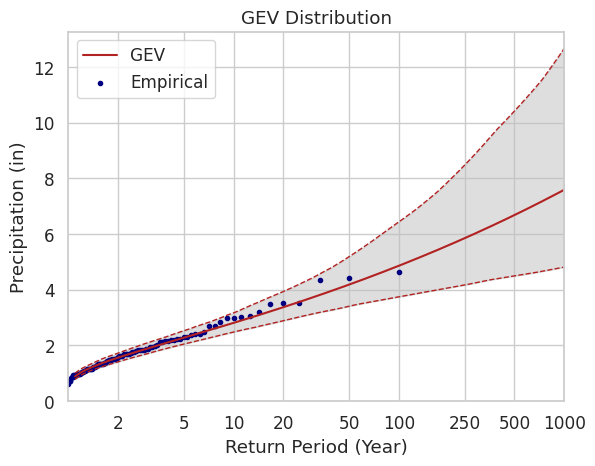

In [61]:
fig, ax = plt.subplots()

return_periods = np.array([2, 5, 10, 20, 50, 100, 250, 500, 1000])


plt.setp(ax.lines, linewidth=2, color='magenta')

ax.set_title("GEV Distribution")
ax.set_xscale('log')
ax.set_xlabel("Return Period (Year)")
ax.set_ylabel("Precipitation (in)")
ax.plot(t, sT, c='firebrick', label='GEV')

ax.plot(t, lower_bound_ci_T, '--', c='firebrick', lw=1)
ax.plot(t, upper_bound_ci_T, '--', c='firebrick', lw=1)
ax.fill_between(t, lower_bound_ci_T, upper_bound_ci_T, color='0.75', alpha=0.5)

ax.scatter(Nmax/N, sorted(df)[::-1], color='navy', marker='.',
           label='Empirical')


plt.legend()

# Set the x-axis ticks to the desired return periods
ax.set_xticks(return_periods, return_periods)
ax.set_xlim(1, max(return_periods))

fig.savefig(f'figures/confidence_intervals.png',
            dpi=100, bbox_inches='tight',
            transparent=False, facecolor='white')

## End Notes

Through this guide I have tried to give you a basic idea how to carry out extreme value analysis (EVA) upon a time series data of interest.

The part 1 shows the basic idea how to carry out extreme value analysis(EVA) from 
* downloading station data using a open source tool of ghcnpy, 
* to check data using pandas and select annual maxima time series, 
* to fit extreme value distributions based on L-moments,
* to present the final output.

The part 2 presents an idea of
* fitting multiple extreme value distributions,
* selecting the best distribution based on a goodness-of-fit measure.

The part 3 shows how to get confidence intervals of the selected distribution's
* its estimated parameters,
* final result (CI at 95% ).

Perhaps, I will introduce a little bit of how to construct extreme precipitation IDF or DDF curves in the next part.

In fact, the analysis will become more complicated in a real practice as high quality data are not always available. Sometimes, you have to spend a lot of time cleaning the data. For example, fill the missing values and check outliers.

This is just a start. You can try more.